# Create Basins for IceLakes

## Data Sources:
- Antarctica: https://nsidc.org/data/nsidc-0709/versions/2
  - Mouginot, J., B. Scheuchl, and E. Rignot. (2017). MEaSUREs Antarctic Boundaries for IPY 2007-2009 from Satellite Radar, Version 2. Boulder, Colorado USA. NASA National Snow and Ice Data Center Distributed Active Archive Center. https://doi.org/10.5067/AXE4121732AD.
- Greenland: https://datadryad.org/stash/dataset/doi:10.7280/D1WT11
  - Mouginot, Jeremie; Rignot, Eric (2019), Glacier catchments/basins for the Greenland Ice Sheet, Dryad, Dataset, https://doi.org/10.7280/D1WT11

In [1]:
%matplotlib widget
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from cmcrameri import cm as cmc
from shapely.geometry import Polygon
from shapely.geometry import MultiPolygon
from shapely.geometry import shape
from shapely.geometry.polygon import orient
import rasterio as rio
from rasterio import plot as rioplot
from rasterio import features

## Antarctica

In [2]:
fn_basin = 'shapefiles/Basins_Antarctica_v02.shp'
fn_shelf = 'shapefiles/IceShelf_Antarctica_v02.shp'
fn_coast = 'shapefiles/Coastline_Antarctica_v02.shp'
fn_ground = 'shapefiles/GroundingLine_Antarctica_v02.shp'

gdf_basin = gpd.read_file(fn_basin)
gdf_shelf = gpd.read_file(fn_shelf)
gdf_coast = gpd.read_file(fn_coast)
gdf_ground = gpd.read_file(fn_ground)

### plot the input data

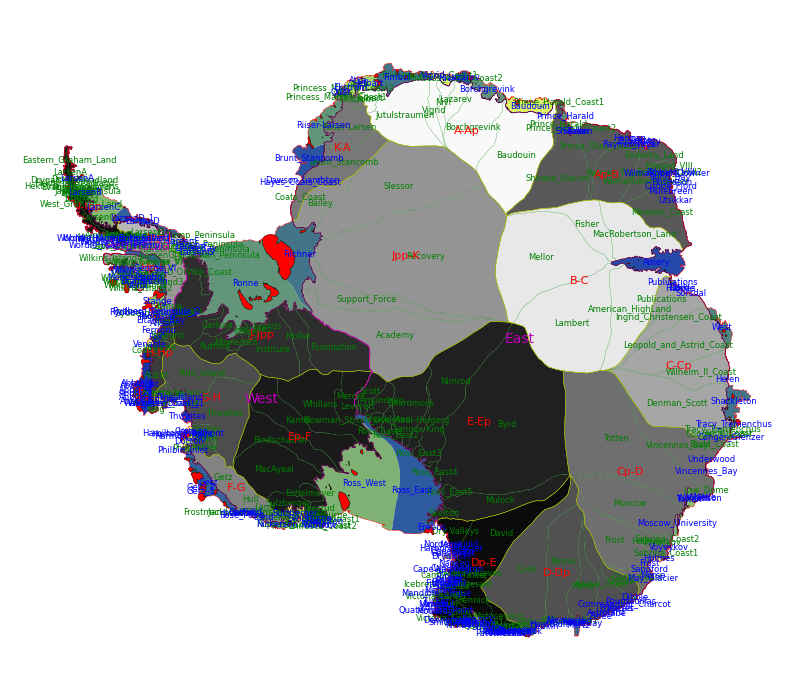

In [3]:
fig, ax = plt.subplots(figsize=[8,7])

gdf_basin.loc[gdf_basin.NAME=='Islands','Subregions'] = 'Islands'
gdf_basin.plot(column='Subregions', cmap=cmc.grayCS, ax=ax)
gdf_basin[gdf_basin.NAME=='Islands'].plot(color='r', ax=ax)
gdf_basin.boundary.plot(color='g', ax=ax, lw=0.1)
gdf_basin.apply(lambda x: ax.annotate(text=x['NAME'], xy=x.geometry.centroid.coords[0], ha='center',va='center',color='g',fontsize=6),axis=1)
gdf_regions = gdf_basin.dissolve('Subregions')[['Regions', 'geometry']].reset_index()
gdf_regions = gdf_regions[gdf_regions.Regions != 'Islands']
gdf_regions.boundary.plot(color='y', ax=ax, lw=0.3)
gdf_regions.apply(lambda x: ax.annotate(text=x['Subregions'], xy=x.geometry.centroid.coords[0], ha='center',va='center',color='r',fontsize=8),axis=1)
gdf_mainregions = gdf_regions.dissolve('Regions')[['geometry']].reset_index()
gdf_mainregions.boundary.plot(color='m', ax=ax, lw=0.5)
gdf_mainregions.apply(lambda x: ax.annotate(text=x['Regions'], xy=x.geometry.centroid.coords[0], ha='center',va='center',color='m',fontsize=10),axis=1)

gdf_shelf.plot(column='NAME', cmap=cmc.imolaS, ax=ax)
gdf_shelf.apply(lambda x: ax.annotate(text=x['NAME'], xy=x.geometry.centroid.coords[0], ha='center',va='center',color='b',fontsize=6),axis=1)

gdf_ground.boundary.plot(color='k', ax=ax, lw=0.3)

gdf_coast.boundary.plot(color='r', ax=ax, lw=0.3)

ax.axis('off')
fig.tight_layout()

### find unresolved shelf associations and unassociated shelves

In [4]:
def find_shelf_errors(gdf_shelf, gdf_basin):
    shelf_names = np.array(gdf_shelf.NAME)
    asso_shelves = []
    for shelves in gdf_basin.Asso_Shelf:
        if type(shelves) is not float:
            asso_shelves += shelves.split('/')
    asso_shelves = np.unique(np.array(asso_shelves))
    asso_shelves = np.array([x for x in asso_shelves if len(x)>0])
    unresolved_associations = np.setdiff1d(asso_shelves, shelf_names)
    print('Unresolved shelf associations:', unresolved_associations)
    unassociated_shelves = np.setdiff1d(shelf_names, asso_shelves)
    print('Unassociated shelves:', unassociated_shelves)
    return unresolved_associations, unassociated_shelves
    
unresolved_associations, unassociated_shelves = find_shelf_errors(gdf_shelf, gdf_basin)

Unresolved shelf associations: ['Moscow' 'Ronne_Ice' 'Wordie']
Unassociated shelves: ['Abbot_1' 'Abbot_2' 'Abbot_3' 'Abbot_4' 'Abbot_5' 'Abbot_6' 'Erebus'
 'Getz_1' 'Getz_2' 'Hamilton_Piedmont' 'Harmon_Bay' 'Holt' 'Hummer_Point'
 'LarsenD_1' 'Moscow_University' 'Ronne' 'Thomson'
 'Wordie_(Airy_Rotz_Seller)' 'Wordie_(Cape_Jeremy)' 'Wordie_(Harriott)'
 'Wordie_(Harriott_Headland)' 'Wordie_(Prospect)']


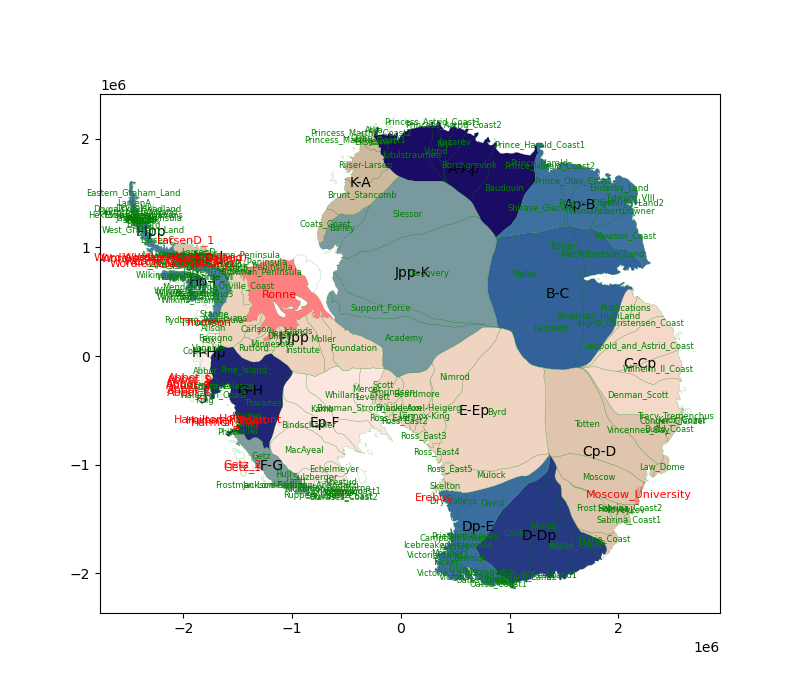

In [5]:
fig, ax = plt.subplots(figsize=[8,7])
gdf_regions.plot(column='Subregions', cmap=cmc.lapazS, ax=ax)
gdf_regions.apply(lambda x: ax.annotate(text=x['Subregions'], xy=x.geometry.centroid.coords[0], ha='center',va='center',color='k',fontsize=10),axis=1)
gdf_basin.boundary.plot(color='g', ax=ax, lw=0.1)
gdf_basin.apply(lambda x: ax.annotate(text=x['NAME'], xy=x.geometry.centroid.coords[0], ha='center',va='center',color='g',fontsize=6),axis=1)
gdf_shelf['not_asso'] = gdf_shelf.apply(lambda x: x.NAME in unassociated_shelves, axis=1)
gdf_shelf[gdf_shelf.not_asso].plot(color=(1,0.5,0.5), ax=ax)
gdf_shelf[gdf_shelf.not_asso].apply(lambda x: ax.annotate(text=x['NAME'], xy=x.geometry.centroid.coords[0], ha='center',va='center',color='r',fontsize=8),axis=1);

### fix ice shelf association inconsistencies

In [6]:
gdf_basin.reset_index(inplace=True, drop=True)

# rename the ice shelves that are in the 
for i in range(len(gdf_basin)):
    thisname = gdf_basin.loc[i].NAME
    asso_shelf = gdf_basin.loc[i].Asso_Shelf
    if type(asso_shelf) is not float:
        
        # replace 'Ronne_Ice' with 'Ronne'
        if 'Ronne_Ice' in asso_shelf: 
            gdf_basin.loc[i, 'Asso_Shelf'] = asso_shelf.replace('Ronne_Ice', 'Ronne')
            print(thisname, gdf_basin.loc[i].Regions, gdf_basin.loc[i].Subregions, ':', asso_shelf, '-->', gdf_basin.loc[i, 'Asso_Shelf'])
            
        # replace 'Moscow' with 'Moscow_University'
        if ('Moscow' in asso_shelf) and ('Moscow_University' not in asso_shelf): 
            gdf_basin.loc[i, 'Asso_Shelf'] = asso_shelf.replace('Moscow', 'Moscow_University')
            print(thisname, gdf_basin.loc[i].Regions, gdf_basin.loc[i].Subregions, ':', asso_shelf, '-->', gdf_basin.loc[i, 'Asso_Shelf'])
            
        # replace 'Wordie' with the associated basin names that have shelves (all but Fleming)
        if ('Wordie' in asso_shelf) and ('Wordie_' not in asso_shelf): 
            if 'Fleming' in thisname:
                gdf_basin.loc[i, 'Asso_Shelf'] = np.nan
            else:
                gdf_basin.loc[i, 'Asso_Shelf'] = asso_shelf.replace('Wordie', 'Wordie_(%s)'%thisname)
                print(thisname, gdf_basin.loc[i].Regions, gdf_basin.loc[i].Subregions, ':', asso_shelf, '-->', gdf_basin.loc[i, 'Asso_Shelf'])
                
for i in range(len(gdf_basin)):
    thisname = gdf_basin.loc[i].NAME
    asso_shelf = gdf_basin.loc[i].Asso_Shelf
    
    # add Abbot, LarsenD, Thomson and Getz island shelves to their respective regions
    if thisname in ['Abbot', 'LarsenD', 'Thomson', 'Getz']:
        to_add = '/'.join([x for x in unassociated_shelves if ((thisname in x) and (x not in str(asso_shelf)))])
        if len(to_add) > 0: 
            if type(asso_shelf) is float:
                gdf_basin.loc[i, 'Asso_Shelf'] = to_add
            else:
                gdf_basin.loc[i, 'Asso_Shelf'] += '/' + to_add
            print(thisname, gdf_basin.loc[i].Regions, gdf_basin.loc[i].Subregions, ':', asso_shelf, '-->', gdf_basin.loc[i, 'Asso_Shelf'])
            
    # add Erebus shelf to Skelton basin
    if thisname == 'Skelton':
        to_add = 'Erebus'
        if to_add not in str(asso_shelf):
            if type(asso_shelf) is float:
                gdf_basin.loc[i, 'Asso_Shelf'] = to_add
            else:
                gdf_basin.loc[i, 'Asso_Shelf'] += '/' + to_add
            print(thisname, gdf_basin.loc[i].Regions, gdf_basin.loc[i].Subregions, ':', asso_shelf, '-->', gdf_basin.loc[i, 'Asso_Shelf'])
            
    # add Hamilton_Piedmont/Harmon_Bay/Holt/Hummer_Point shelves to Kohler basin
    if thisname == 'Kohler':
        to_add = 'Hamilton_Piedmont/Harmon_Bay/Holt/Hummer_Point'
        if to_add not in str(asso_shelf):
            if type(asso_shelf) is float:
                gdf_basin.loc[i, 'Asso_Shelf'] = to_add
            else:
                gdf_basin.loc[i, 'Asso_Shelf'] += '/' + to_add
            print(thisname, gdf_basin.loc[i].Regions, gdf_basin.loc[i].Subregions, ':', asso_shelf, '-->', gdf_basin.loc[i, 'Asso_Shelf'])

# there are two Fox ice shelves, one in EAIS and one in WAIS, replace with Fox_East and Fox_West
gdf_shelf.loc[gdf_shelf.NAME == 'Fox', 'NAME'] = gdf_shelf.loc[gdf_shelf.NAME == 'Fox'].apply(lambda x: '%s_%s' % (x.NAME, x.Regions), axis=1)
for i in range(len(gdf_basin)):
    thisname = gdf_basin.loc[i].NAME
    asso_shelf = gdf_basin.loc[i].Asso_Shelf
    if ('Fox' in str(asso_shelf)) and ('Fox_' not in str(asso_shelf)):
        gdf_basin.loc[i, 'Asso_Shelf'] = asso_shelf.replace('Fox', '%s_%s' % (asso_shelf, gdf_basin.loc[i].Regions))
        print(thisname, gdf_basin.loc[i].Regions, gdf_basin.loc[i].Subregions, ':', asso_shelf, '-->', gdf_basin.loc[i, 'Asso_Shelf'])

# check that there is no more unresolved ice shelves
print(' ')
unresolved_associations, unassociated_shelves = find_shelf_errors(gdf_shelf, gdf_basin)

Moscow East Cp-D : Moscow --> Moscow_University
Rutford West J-Jpp : Ronne_Ice --> Ronne
Carlson West J-Jpp : Ronne_Ice --> Ronne
Evans West J-Jpp : Ronne_Ice --> Ronne
Harriott_Headland Peninsula I-Ipp : Wordie --> Wordie_(Harriott_Headland)
Prospect Peninsula I-Ipp : Wordie --> Wordie_(Prospect)
Foundation West J-Jpp : Ronne_Ice --> Ronne
Minnesota West J-Jpp : Ronne_Ice --> Ronne
Union West J-Jpp : Ronne_Ice --> Ronne
Hercules West J-Jpp : Ronne_Ice --> Ronne
Moller West J-Jpp : Ronne_Ice --> Ronne
Institute West J-Jpp : Ronne_Ice --> Ronne
D_Orville_Coast West J-Jpp : Ronne_Ice --> Ronne
Airy_Rotz_Seller Peninsula I-Ipp : Wordie --> Wordie_(Airy_Rotz_Seller)
Cape_Jeremy Peninsula Hp-I : Wordie --> Wordie_(Cape_Jeremy)
Harriott Peninsula I-Ipp : Wordie --> Wordie_(Harriott)
Skelton East E-Ep : Ross_East --> Ross_East/Erebus
Kohler West G-H : Dotson --> Dotson/Hamilton_Piedmont/Harmon_Bay/Holt/Hummer_Point
Getz West F-G : Getz --> Getz/Getz_1/Getz_2
Abbot West H-Hp : Abbot --> Abbot/

### merge subregions with associated ice shelves and ajdacent islands

In [7]:
gdf_basin.loc[gdf_basin.NAME=='Islands','Subregions'] = 'Islands'
def get_shelves_list(x):
    if type(x.Asso_Shelf) is not float: return x.Asso_Shelf.split('/')
    else: return []
gdf_basin['Asso_Shelf'] = gdf_basin.apply(get_shelves_list, axis=1)
gdf_regions = gdf_basin.dissolve('Subregions')[['Regions', 'geometry']]
regions_group = gdf_basin.groupby(by="Subregions")
gdf_regions['shelves'] = regions_group['Asso_Shelf'].apply(lambda x: np.unique([item for sub in x for item in sub if item]))
gdf_regions.reset_index(inplace=True)
gdf_regions['NAME'] = gdf_regions.Subregions
gdf_regions['TYPE'] = 'GR'

gdf_shelf.set_index('NAME', inplace=True)

shlvs = []
for i in range(len(gdf_regions)):
    r = gdf_regions.iloc[i]
    for shelf in r.shelves:
            sh = gdf_shelf.loc[shelf]
            gdf_regions.loc[len(gdf_regions)] = [r.Subregions, sh.Regions, sh.geometry, np.nan, shelf, sh.TYPE]
            shlvs.append(shelf)

gdf_regions.drop('shelves', axis=1, inplace=True)
gdf_merged = gdf_regions.dissolve('Subregions')[['Regions', 'geometry']].reset_index()
gdf_merged = gdf_merged[gdf_merged.Subregions != 'Islands'].copy()

# add each island to the subregion (including shelves) that overlaps most with the island's boundary
for geom in gdf_regions[gdf_regions.NAME == 'Islands'].iloc[0].geometry.geoms:
    r = gdf_merged[gdf_merged.boundary.intersects(geom.boundary)]
    if len(r) > 0:
        if len(r) > 1:
            r = r.iloc[r.intersection(geom.boundary).length.argmax()]
        else:
            r = r.iloc[0]
        gdf_regions.loc[len(gdf_regions)] = [r.Subregions, r.Regions, geom, 'island', 'IS']

gdf_merged = gdf_regions.dissolve('Subregions')[['Regions', 'geometry']].reset_index()
gdf_merged = gdf_merged[gdf_merged.Subregions != 'Islands'].set_crs('EPSG:3031').copy()

### Plot the resulting regions

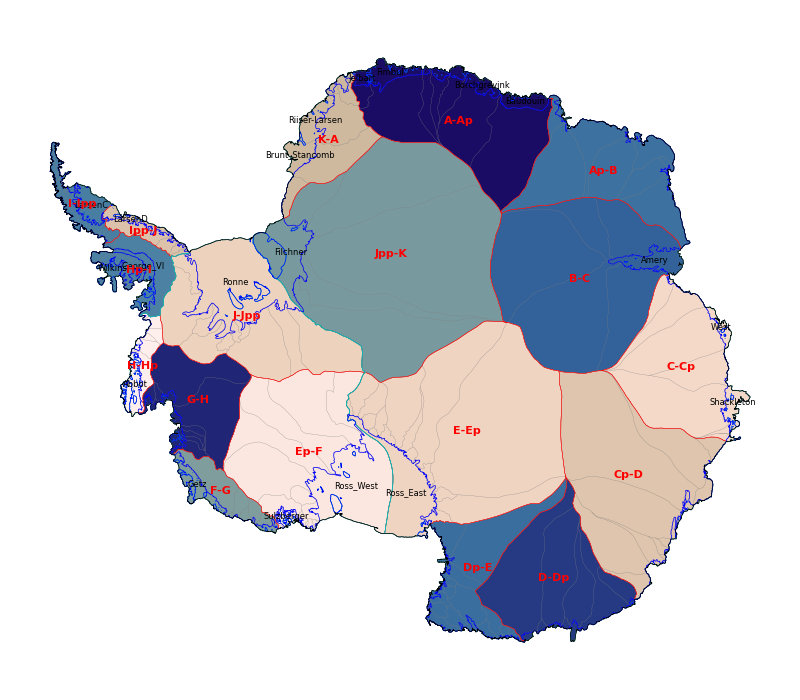

In [8]:
fig, ax = plt.subplots(figsize=[8,7])
gdf_merged.plot(column='Subregions', cmap=cmc.lapazS, ax=ax)

gdf_mainregions = gdf_regions.dissolve('Regions')[['geometry']].reset_index()
gdf_basin.boundary.plot(color='gray', ax=ax, lw=0.1)
gdf_shelf.boundary.plot(color='gray', ax=ax, lw=0.1)
gdf_merged.boundary.plot(color='r', ax=ax, lw=0.3)
gdf_mainregions.boundary.plot(color='c', ax=ax, lw=0.5)
gdf_ground.boundary.plot(color='b', ax=ax, lw=0.5)
gdf_coast.boundary.plot(color='k', ax=ax, lw=0.5)

def add_shelf_label(shelf, min_area=1e10):
    if shelf.geometry.area > min_area: 
        ax.annotate(text=shelf['NAME'], xy=shelf.geometry.centroid.coords[0], ha='center',va='center',
                                       color='k',fontsize=6)
gdf_shelf.reset_index().apply(add_shelf_label, axis=1);

gdf_merged.apply(lambda x: ax.annotate(text=x['Subregions'], xy=x.geometry.centroid.coords[0], ha='center',va='center',
                                       color='r',fontsize=8, weight='bold'),axis=1);

ax.axis('off')
fig.tight_layout()

### Threshold by elevation
Could use better elevation thresholds? Estimated from data in 
- Tuckett, P., Ely, J., Sole, A., Livingstone, S., Jones, J., Lea, J., & Gilbert, E. (2022). Continent-scale mapping reveals a rise in East Antarctic surface meltwater.
- Tuckett, P. A., Ely, J. C., Sole, A. J., Lea, J. M., Livingstone, S. J., Jones, J. M., & van Wessem, J. M. (2021). Automated mapping of the seasonal evolution of surface meltwater and its links to climate on the Amery Ice Shelf, Antarctica. The Cryosphere, 15(12), 5785-5804.

In [9]:
elevation_threshold = 1500
coast_buffer = 10000
fn_dem = 'DEMs/rema_mosaic_1km_v2.0_filled_cop30_dem.tif'

def threshold_geotiff_to_geodataframe(input_path, threshold):
    with rio.open(input_path) as src:
        profile = src.profile
        data = src.read(1)  # Read the first band
        thresholded_data = data < threshold
        mask = thresholded_data.astype('uint8')
        shapes = features.shapes(mask, transform=src.transform)
        polygons = []
        for geom, value in shapes:
            if value == 1:
                polygons.append(shape(geom))
        gdf = gpd.GeoDataFrame(geometry=polygons, crs=profile['crs']).dissolve()[['geometry']].reset_index(drop=True)
        gdf['geometry'] = gdf.geometry.simplify(src.res[0], preserve_topology=True)
        return gdf

gdf_dem = threshold_geotiff_to_geodataframe(fn_dem, elevation_threshold)
gdf_thresh = gdf_merged.copy()
gdf_thresh['geometry'] = gdf_thresh.intersection(gdf_dem.iloc[0].geometry)
boundary = gdf_merged.intersection(gdf_coast.iloc[0].geometry.boundary.buffer(coast_buffer))
gdf_thresh['geometry'] = gdf_thresh.union(boundary)

def fill_holes(x):
    if x.geometry.geom_type == 'Polygon':
        poly = x.geometry
        if poly.interiors: 
            return Polygon(list(poly.exterior.coords))
        else: 
            return poly
    if x.geometry.geom_type == 'MultiPolygon':
        for poly in x.geometry.geoms:
            if poly.interiors: 
                poly_filled = Polygon(list(poly.exterior.coords))
            else: 
                poly_filled = poly
            if poly_filled.intersects(gdf_coast.boundary.geometry.iloc[0]):
                return poly_filled
        
gdf_thresh['geometry'] = gdf_thresh.apply(fill_holes, axis=1)

### Plot the resulting regions that are likely to have surface melt

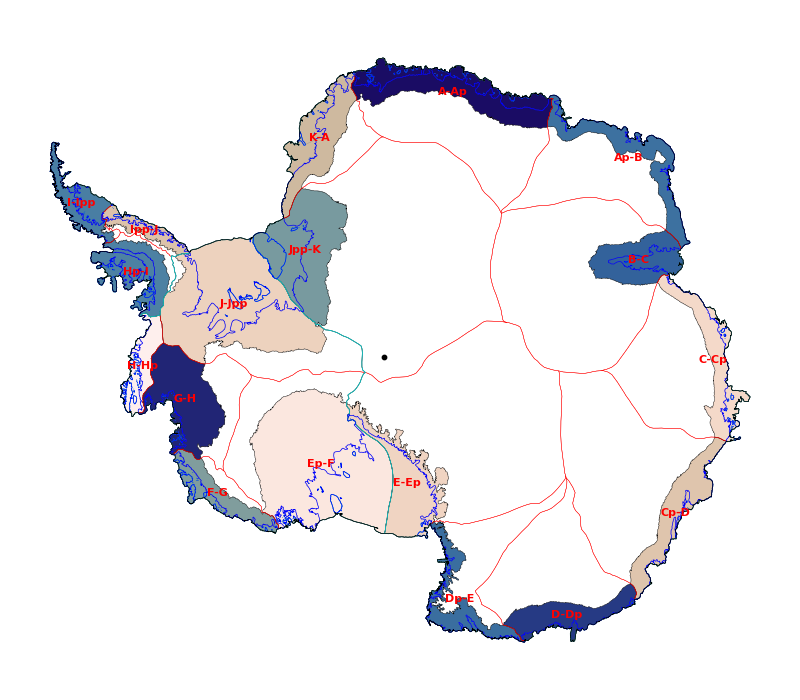

In [10]:
fig, ax = plt.subplots(figsize=[8,7])
gdf_thresh.plot(column='Subregions', cmap=cmc.lapazS, ax=ax)
gdf_thresh.boundary.plot(color='k', ax=ax, lw=0.3)
gdf_shelf.boundary.plot(color='gray', ax=ax, lw=0.1)
gdf_merged.boundary.plot(color='r', ax=ax, lw=0.3)
gdf_mainregions.boundary.plot(color='c', ax=ax, lw=0.5)
gdf_ground.boundary.plot(color='b', ax=ax, lw=0.5)
gdf_coast.boundary.plot(color='k', ax=ax, lw=0.5)
gdf_thresh.apply(lambda x: ax.annotate(text=x['Subregions'], xy=x.geometry.centroid.coords[0], ha='center',va='center',
                                       color='r',fontsize=8, weight='bold'),axis=1);
ax.scatter(0,0,s=10,color='k')

ax.axis('off')
fig.tight_layout()

### Write polygons to geojson files for NSIDC queries

In [11]:
simplify_tol = 10000 # 10 km 
gdf_thresh_simple = gdf_thresh.copy()
gdf_thresh['geometry'] = gdf_thresh.apply(lambda x: orient(x.geometry, sign=1.0), axis=1)
gdf_thresh_simple['geometry'] = gdf_thresh.apply(lambda x: orient(x.geometry.buffer(simplify_tol).simplify(simplify_tol, preserve_topology=True), sign=1.0), axis=1)

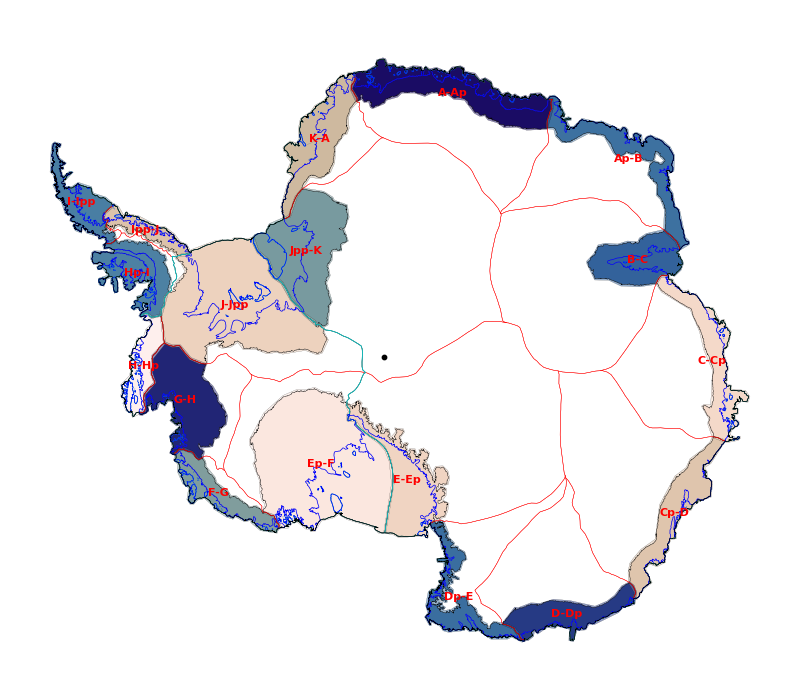

In [12]:
fig, ax = plt.subplots(figsize=[8,7])
gdf_thresh.plot(column='Subregions', cmap=cmc.lapazS, ax=ax)
gdf_thresh_simple.plot(column='Subregions', cmap=cmc.lapazS, alpha=0.5, ax=ax)
gdf_thresh.boundary.plot(color='k', ax=ax, lw=0.3)
gdf_thresh_simple.boundary.plot(color='k', ax=ax, lw=0.1)
gdf_shelf.boundary.plot(color='gray', ax=ax, lw=0.1)
gdf_merged.boundary.plot(color='r', ax=ax, lw=0.3)
gdf_mainregions.boundary.plot(color='c', ax=ax, lw=0.5)
gdf_ground.boundary.plot(color='b', ax=ax, lw=0.5)
gdf_coast.boundary.plot(color='k', ax=ax, lw=0.5)
gdf_thresh_simple.apply(lambda x: ax.annotate(text=x['Subregions'], xy=x.geometry.centroid.coords[0], ha='center',va='center',
                                       color='r',fontsize=8, weight='bold'),axis=1);
ax.scatter(0,0,s=10,color='k')

ax.axis('off')
fig.tight_layout()

ant_gdf_thresh = gdf_thresh.copy()
ant_gdf_thresh_simple = gdf_thresh_simple.copy()
ant_gdf_shelf = gdf_shelf.copy()
ant_gdf_merged = gdf_merged.copy()
ant_gdf_mainregions = gdf_mainregions.copy()
ant_gdf_ground = gdf_ground.copy()
ant_gdf_coast = gdf_coast.copy()

In [13]:
for i in range(len(gdf_thresh)):
    row = gdf_thresh.iloc[i]

    # write full polygon
    poly = orient(row.geometry, sign=1.0)
    out_fn = '../geojsons/ANT_%i_%s_%s.geojson' % (elevation_threshold, row.Regions, row.Subregions)
    gpd.GeoSeries(poly).set_crs(gdf_thresh.crs).to_crs('EPSG:4326').to_file(out_fn, driver='GeoJSON')
    print('Wrote file:', out_fn)

    poly = orient(row.geometry.buffer(simplify_tol).simplify(simplify_tol, preserve_topology=True), sign=1.0)
    out_fn = '../geojsons/simplified_ANT_%i_%s_%s.geojson' % (elevation_threshold, row.Regions, row.Subregions)
    gpd.GeoSeries(poly).set_crs(gdf_thresh.crs).to_crs('EPSG:4326').to_file(out_fn, driver='GeoJSON')
    print('Wrote file:', out_fn)

Wrote file: ../geojsons/ANT_1500_East_A-Ap.geojson
Wrote file: ../geojsons/simplified_ANT_1500_East_A-Ap.geojson
Wrote file: ../geojsons/ANT_1500_East_Ap-B.geojson
Wrote file: ../geojsons/simplified_ANT_1500_East_Ap-B.geojson
Wrote file: ../geojsons/ANT_1500_East_B-C.geojson
Wrote file: ../geojsons/simplified_ANT_1500_East_B-C.geojson
Wrote file: ../geojsons/ANT_1500_East_C-Cp.geojson
Wrote file: ../geojsons/simplified_ANT_1500_East_C-Cp.geojson
Wrote file: ../geojsons/ANT_1500_East_Cp-D.geojson
Wrote file: ../geojsons/simplified_ANT_1500_East_Cp-D.geojson
Wrote file: ../geojsons/ANT_1500_East_D-Dp.geojson
Wrote file: ../geojsons/simplified_ANT_1500_East_D-Dp.geojson
Wrote file: ../geojsons/ANT_1500_East_Dp-E.geojson
Wrote file: ../geojsons/simplified_ANT_1500_East_Dp-E.geojson
Wrote file: ../geojsons/ANT_1500_East_E-Ep.geojson
Wrote file: ../geojsons/simplified_ANT_1500_East_E-Ep.geojson
Wrote file: ../geojsons/ANT_1500_West_Ep-F.geojson
Wrote file: ../geojsons/simplified_ANT_1500_Wes

## Greenland

In [14]:
fn = 'shapefiles/Greenland_Basins_PS_v1.4.2.shp'
gdf_basin = gpd.read_file(fn)
gdf_basin['geometry'] = gdf_basin.geometry.buffer(1)

### plot the data

,SUBREGION1,NAME,GL_TYPE,geometry
0,NW,UMIAMMAKKU_ISBRAE,TW,"POLYGON ((-250013.138 -1962483.360, -250013.19..."
1,CE,GEIKIE_UNNAMED_VESTFORD_S,TW,"POLYGON ((669064.908 -2093801.345, 669065.003 ..."
2,CW,RINK_ISBRAE,TW,"POLYGON ((245237.056 -1890271.256, 245237.053 ..."
3,CW,KANGERLUSSUUP_SERMERSUA,TW,"POLYGON ((245015.556 -1891216.877, 245015.530 ..."
4,CW,CW_NONAME3,LT,"POLYGON ((-196828.395 -2054376.459, -196828.29..."


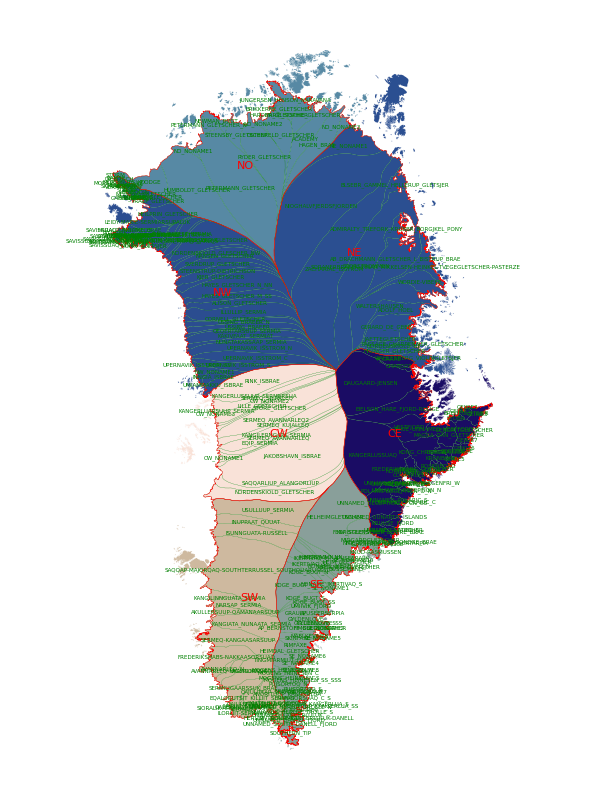

In [15]:
fig, ax = plt.subplots(figsize=[6,8])

gdf_basin.plot(column='SUBREGION1', cmap=cmc.lapazS, ax=ax)
is_ice_cap = gdf_basin.apply(lambda x: 'ICE_CAPS' in x.NAME, axis=1)
gdf_gris = gdf_basin[~is_ice_cap].copy()
gdf_gris.boundary.plot(color='g', ax=ax, lw=0.1)
gdf_gris.apply(lambda x: ax.annotate(text=x['NAME'], xy=x.geometry.centroid.coords[0], ha='center',va='center',color='g',fontsize=4),axis=1)
gdf_regions = gdf_gris.dissolve('SUBREGION1')[['geometry']].reset_index()
gdf_regions.boundary.plot(color='r', ax=ax, lw=0.3)
gdf_regions.apply(lambda x: ax.annotate(text=x['SUBREGION1'], xy=x.geometry.centroid.coords[0], ha='center',va='center',color='r',fontsize=8),axis=1)

ax.axis('off')
fig.tight_layout()

gdf_basin.head()

### merge subregions and remove holes from region polygons

In [16]:
gdf_regions = gdf_gris.dissolve('SUBREGION1')[['geometry']].reset_index()
def close_holes(poly):
        if poly.interiors: return Polygon(list(poly.exterior.coords))
        else: return poly
gdf_regions['geometry'] = gdf_regions.geometry.apply(lambda x: close_holes(x))

### plot the resulting data

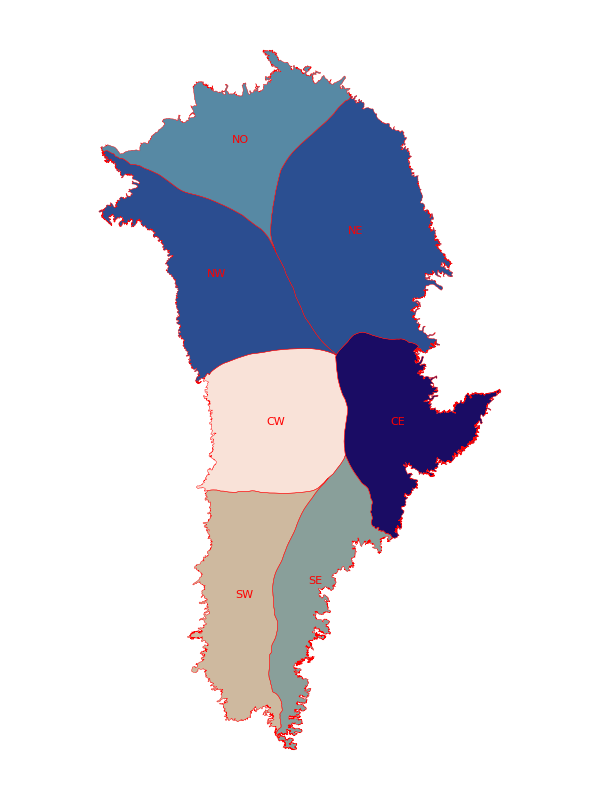

In [17]:
fig, ax = plt.subplots(figsize=[6,8])
gdf_regions.plot(column='SUBREGION1', cmap=cmc.lapazS, ax=ax)
gdf_regions.boundary.plot(color='r', ax=ax, lw=0.3)
gdf_regions.apply(lambda x: ax.annotate(text=x['SUBREGION1'], xy=x.geometry.centroid.coords[0], ha='center',va='center',color='r',fontsize=8),axis=1)
ax.axis('off')
fig.tight_layout()

### Threshold by elevation

In [18]:
elevation_threshold = 2500
coast_buffer = 10000
fn_dem = 'DEMs/arcticdem_mosaic_1km_v4.1_dem.tif'

def threshold_geotiff_to_geodataframe(input_path, threshold):
    with rio.open(input_path) as src:
        profile = src.profile
        data = src.read(1)  # Read the first band
        thresholded_data = data < threshold
        mask = thresholded_data.astype('uint8')
        shapes = features.shapes(mask, transform=src.transform)
        polygons = []
        for geom, value in shapes:
            if value == 1:
                polygons.append(shape(geom))
        gdf = gpd.GeoDataFrame(geometry=polygons, crs=profile['crs']).dissolve()[['geometry']].reset_index(drop=True)
        gdf['geometry'] = gdf.geometry.simplify(src.res[0], preserve_topology=True)
        return gdf

gdf_dem = threshold_geotiff_to_geodataframe(fn_dem, elevation_threshold)
gdf_thresh = gdf_regions.copy()
gdf_thresh['geometry'] = gdf_thresh.intersection(gdf_dem.iloc[0].geometry)
gdf_coast = gdf_regions.dissolve()
boundary = gdf_regions.intersection(gdf_coast.iloc[0].geometry.boundary.buffer(coast_buffer))
gdf_thresh['geometry'] = gdf_thresh.union(boundary)

def fill_holes(x):
    if x.geometry.geom_type == 'Polygon':
        poly = x.geometry
        if poly.interiors: 
            return Polygon(list(poly.exterior.coords))
        else: 
            return poly
    if x.geometry.geom_type == 'MultiPolygon':
        for poly in x.geometry.geoms:
            if poly.interiors: 
                poly_filled = Polygon(list(poly.exterior.coords))
            else: 
                poly_filled = poly
            if poly_filled.intersects(gdf_coast.boundary.geometry.iloc[0]):
                return poly_filled
        
gdf_thresh['geometry'] = gdf_thresh.apply(fill_holes, axis=1)

### plot the final regions

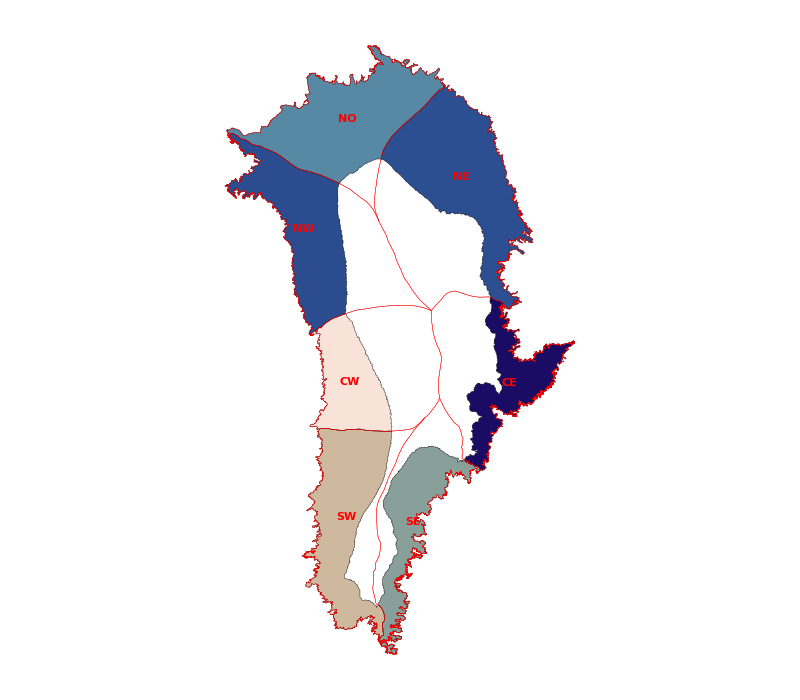

In [19]:
fig, ax = plt.subplots(figsize=[8,7])
gdf_thresh.plot(column='SUBREGION1', cmap=cmc.lapazS, ax=ax)
gdf_thresh.boundary.plot(color='k', ax=ax, lw=0.3)
gdf_regions.boundary.plot(color='r', ax=ax, lw=0.3)
gdf_thresh.apply(lambda x: ax.annotate(text=x['SUBREGION1'], xy=x.geometry.centroid.coords[0], ha='center',va='center',
                                       color='r',fontsize=8, weight='bold'),axis=1);

ax.axis('off')
fig.tight_layout()

In [20]:
simplify_tol = 10000 # 10 km 
gdf_thresh_simple = gdf_thresh.copy()
gdf_thresh['geometry'] = gdf_thresh.apply(lambda x: orient(x.geometry, sign=1.0), axis=1)
gdf_thresh_simple['geometry'] = gdf_thresh.apply(lambda x: orient(x.geometry.buffer(simplify_tol).simplify(simplify_tol, preserve_topology=True), sign=1.0), axis=1)

gre_gdf_thresh = gdf_thresh.copy()
gre_gdf_thresh_simple = gdf_thresh_simple.copy()
gre_gdf_regions = gdf_regions.copy()

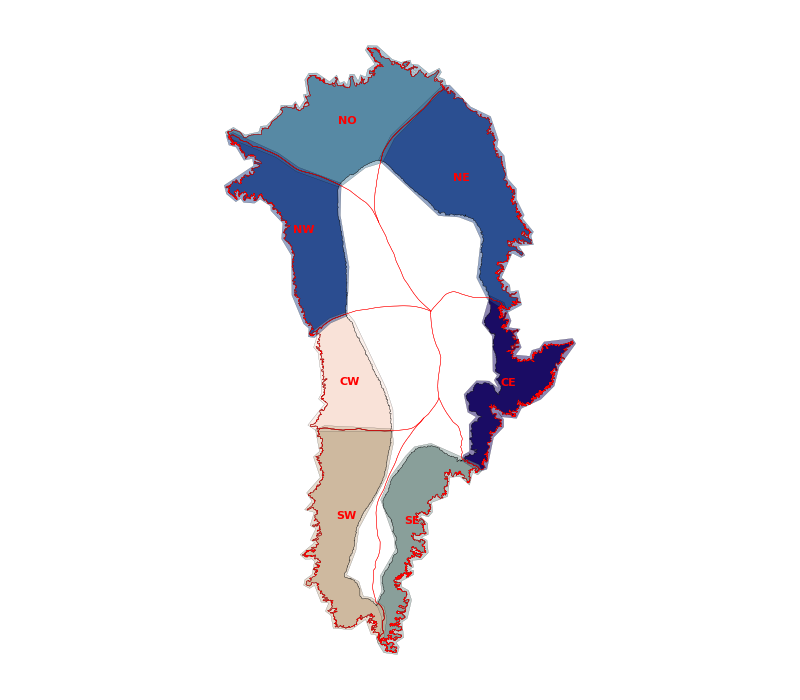

In [21]:
fig, ax = plt.subplots(figsize=[8,7])
gdf_thresh.plot(column='SUBREGION1', cmap=cmc.lapazS, ax=ax)
gdf_thresh_simple.plot(column='SUBREGION1', cmap=cmc.lapazS, ax=ax, alpha=0.5)
gdf_thresh_simple.boundary.plot(color='k', ax=ax, lw=0.1)
gdf_thresh.boundary.plot(color='k', ax=ax, lw=0.3)
gdf_regions.boundary.plot(color='r', ax=ax, lw=0.3)
gdf_thresh.apply(lambda x: ax.annotate(text=x['SUBREGION1'], xy=x.geometry.centroid.coords[0], ha='center',va='center',
                                       color='r',fontsize=8, weight='bold'),axis=1);

ax.axis('off')
fig.tight_layout()

### Write polygons to geojson files for NSIDC queries

In [22]:
for i in range(len(gre_gdf_thresh)):
    row = gre_gdf_thresh.iloc[i]

    # write full polygon
    poly = orient(row.geometry, sign=1.0)
    out_fn = '../geojsons/GRE_%i_%s.geojson' % (elevation_threshold, row.SUBREGION1)
    gpd.GeoSeries(poly).set_crs(gre_gdf_thresh.crs).to_crs('EPSG:4326').to_file(out_fn, driver='GeoJSON')
    print('Wrote file:', out_fn)

    poly = orient(row.geometry.buffer(simplify_tol).simplify(simplify_tol, preserve_topology=True), sign=1.0)
    out_fn = '../geojsons/simplified_GRE_%i_%s.geojson' % (elevation_threshold, row.SUBREGION1)
    gpd.GeoSeries(poly).set_crs(gre_gdf_thresh.crs).to_crs('EPSG:4326').to_file(out_fn, driver='GeoJSON')
    print('Wrote file:', out_fn)

Wrote file: ../geojsons/GRE_2500_CE.geojson
Wrote file: ../geojsons/simplified_GRE_2500_CE.geojson
Wrote file: ../geojsons/GRE_2500_CW.geojson
Wrote file: ../geojsons/simplified_GRE_2500_CW.geojson
Wrote file: ../geojsons/GRE_2500_NE.geojson
Wrote file: ../geojsons/simplified_GRE_2500_NE.geojson
Wrote file: ../geojsons/GRE_2500_NO.geojson
Wrote file: ../geojsons/simplified_GRE_2500_NO.geojson
Wrote file: ../geojsons/GRE_2500_NW.geojson
Wrote file: ../geojsons/simplified_GRE_2500_NW.geojson
Wrote file: ../geojsons/GRE_2500_SE.geojson
Wrote file: ../geojsons/simplified_GRE_2500_SE.geojson
Wrote file: ../geojsons/GRE_2500_SW.geojson
Wrote file: ../geojsons/simplified_GRE_2500_SW.geojson


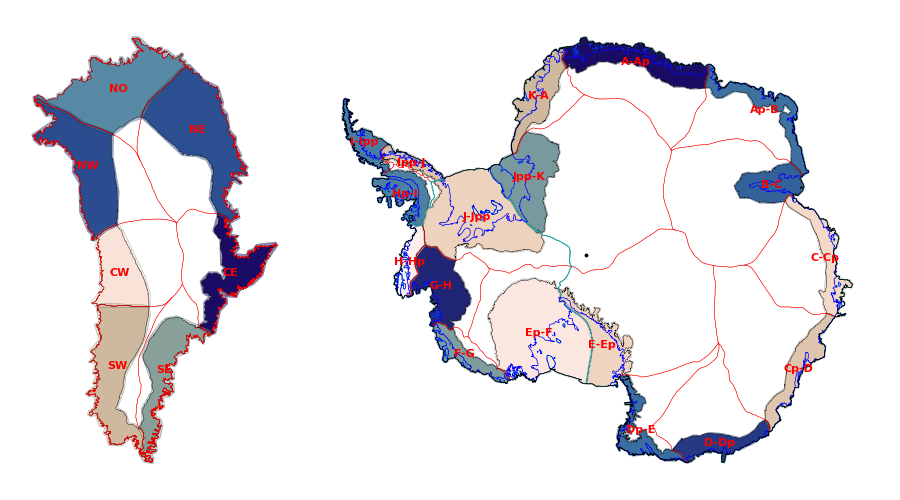

In [23]:
fig = plt.figure(figsize=[9,5])
gs = fig.add_gridspec(1, 3)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1:])

# Antarctica
ax = ax2
ant_gdf_thresh.plot(column='Subregions', cmap=cmc.lapazS, ax=ax)
ant_gdf_thresh_simple.plot(column='Subregions', cmap=cmc.lapazS, alpha=0.5, ax=ax)
ant_gdf_thresh.boundary.plot(color='k', ax=ax, lw=0.3)
ant_gdf_thresh_simple.boundary.plot(color='k', ax=ax, lw=0.1)
ant_gdf_shelf.boundary.plot(color='gray', ax=ax, lw=0.1)
ant_gdf_merged.boundary.plot(color='r', ax=ax, lw=0.3)
ant_gdf_mainregions.boundary.plot(color='c', ax=ax, lw=0.5)
ant_gdf_ground.boundary.plot(color='b', ax=ax, lw=0.5)
ant_gdf_coast.boundary.plot(color='k', ax=ax, lw=0.5)
ant_gdf_thresh_simple.apply(lambda x: ax.annotate(text=x['Subregions'], xy=x.geometry.centroid.coords[0], ha='center',va='center',
                                       color='r',fontsize=8, weight='bold'),axis=1);
ax.scatter(0,0,s=3,color='k')
ax.axis('off')

# Greenland
ax = ax1
gre_gdf_thresh.plot(column='SUBREGION1', cmap=cmc.lapazS, ax=ax)
gre_gdf_thresh_simple.plot(column='SUBREGION1', cmap=cmc.lapazS, ax=ax, alpha=0.5)
gre_gdf_thresh_simple.boundary.plot(color='k', ax=ax, lw=0.1)
gre_gdf_thresh.boundary.plot(color='k', ax=ax, lw=0.3)
gre_gdf_regions.boundary.plot(color='r', ax=ax, lw=0.3)
gre_gdf_thresh.apply(lambda x: ax.annotate(text=x['SUBREGION1'], xy=x.geometry.centroid.coords[0], ha='center',va='center',
                                       color='r',fontsize=8, weight='bold'),axis=1);
ax.axis('off')

fig.tight_layout()
fig.savefig('basins_plot_large.jpg', dpi=900)
fig.savefig('basins_plot_small.jpg', dpi=150)